<a href="https://colab.research.google.com/github/shubham1m/MusicGeneration/blob/main/MusicWithMuseGAN_Compose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install music21==5.3.0

     |████████████████████████████████| 18.0MB 200kB/s 
  Created wheel for music21: filename=music21-5.3.0-cp37-none-any.whl size=21291740 sha256=e17899aa81af59dbc28f744158b60738bf42e4ac893f3bde1947e336b900ab7b
  Stored in directory: /root/.cache/pip/wheels/53/8b/a6/be1921c60a68f0bea31c6b6a0a7b125badd61294d6a694407f
Successfully built music21
  Found existing installation: music21 5.5.0
    Uninstalling music21-5.5.0:
      Successfully uninstalled music21-5.5.0


In [ ]:
# enables music21 to render images of musical notes
print('installing lilypond...')
!apt-get install lilypond #> /dev/null

# converts midi files to wav files into order to play them
print('installing fluidsynth...')
!apt-get install fluidsynth #> /dev/null
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

print('done!')

installing lilypond...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lmodern fonts-noto-mono ghostscript gsfonts
  libauthen-sasl-perl libcupsfilters1 libcupsimage2 libdata-dump-perl
  libencode-locale-perl libfile-listing-perl libfont-afm-perl libgs9
  libgs9-common libhtml-form-perl libhtml-format-perl libhtml-parser-perl
  libhtml-tagset-perl libhtml-tree-perl libhttp-cookies-perl
  libhttp-daemon-perl libhttp-date-perl libhttp-message-perl
  libhttp-negotiate-perl libijs-0.35 libio-html-perl libio-socket-ssl-perl
  libjbig2dec0 libkpathsea6 liblwp-mediatypes-perl liblwp-protocol-https-perl
  libmailtools-perl libnet-http-perl libnet-smtp-ssl-perl libnet-ssleay-perl
  libpotrace0 libptexenc1 libsynctex1 libtexlua52 libte

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import types

!cp /content/drive/MyDrive/ColabNotebooks/models/MuseGAN.py .
from MuseGAN import MuseGAN

!cp /content/drive/MyDrive/ColabNotebooks/utils/loaders.py .
from loaders import load_music

import music21
from music21 import midi
from music21 import note, stream, duration

from IPython.display import Image, Audio

In [ ]:
!fluidsynth --version
print('-------------------------')
!lilypond --version
print('-------------------------')
music21.__version__

FluidSynth version 1.1.9
Copyright (C) 2000-2018 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

FluidSynth 1.1.9
-------------------------
GNU LilyPond 2.18.2

Copyright (c) 1996--2012 by
  Han-Wen Nienhuys <hanwen@xs4all.nl>
  Jan Nieuwenhuizen <janneke@gnu.org>
  and others.

This program is free software.  It is covered by the GNU General Public
License and you are welcome to change it and/or distribute copies of it
under certain conditions.  Invoke as `lilypond --warranty' for more
information.

-------------------------


'5.3.0'

In [ ]:
import tensorflow
tensorflow.keras.__version__

'2.4.0'

In [ ]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [ ]:
def show(music):
  display(Image(str(music.write('lily.png'))))

def play(music):
  filename = music.write('mid')
  !fluidsynth -ni font.sf2 $filename -F $filename\.wav -r 16000 > /dev/null
  display(Audio(filename + '.wav'))

In [ ]:
# run params
SECTION = '/content/drive/MyDrive/ColabNotebooks/MusicGeneration/MusicWithMuseGAN_Data'
RUN_ID = '0017'
DATA_NAME = 'chorales'
FILENAME = 'Jsb16thSeparated.npz'
RUN_FOLDER = '{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

#Data

In [ ]:
BATCH_SIZE = 64
n_bars = 2
n_steps_per_bar = 16
n_pitches = 84
n_tracks = 4

data_binary, data_ints, raw_data = load_music(RUN_FOLDER, FILENAME, n_bars, n_steps_per_bar)
# data_binary = np.squeeze(data_binary)

In [ ]:
gan = MuseGAN(input_dim = data_binary.shape[1:]
        , critic_learning_rate = 0.001
        , generator_learning_rate = 0.001
        , optimiser = 'adam'
        , grad_weight = 10
        , z_dim = 32
        , batch_size = BATCH_SIZE
        , n_tracks = n_tracks
        , n_bars = n_bars
        , n_steps_per_bar = n_steps_per_bar
        , n_pitches = n_pitches
        )

In [ ]:
gan.load_weights(RUN_FOLDER, None)

In [ ]:
gan.generator.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
melody_input (InputLayer)       [(None, 4, 32)]      0                                            
__________________________________________________________________________________________________
chords_input (InputLayer)       [(None, 32)]         0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 32)           0           melody_input[0][0]               
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 32)           0           melody_input[0][0]               
___________________________________________________________________________________________

In [ ]:
gan.critic.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
critic_input (InputLayer)    [(None, 2, 16, 84, 4)]    0         
_________________________________________________________________
conv3d (Conv3D)              multiple                  1152      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      multiple                  0         
_________________________________________________________________
conv3d_1 (Conv3D)            multiple                  16512     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    multiple                  0         
_________________________________________________________________
conv3d_2 (Conv3D)            multiple                  196736    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    multiple                  0     

#View

In [ ]:
chords_noise = np.random.normal(0, 1, (1, gan.z_dim))
style_noise = np.random.normal(0, 1, (1, gan.z_dim))
melody_noise = np.random.normal(0, 1, (1, gan.n_tracks, gan.z_dim))
groove_noise = np.random.normal(0, 1, (1, gan.n_tracks, gan.z_dim))

In [ ]:
gen_scores = gan.generator.predict([chords_noise, style_noise, melody_noise, groove_noise])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
np.argmax(gen_scores[0,0,0:4,:,3], axis = 1)

array([54, 54, 55, 55])

In [ ]:
gen_scores[0,0,0:4,60,3] = 0.02347812

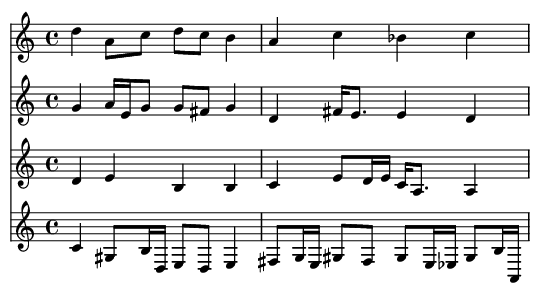

In [ ]:
filename = 'example'
gan.notes_to_midi(RUN_FOLDER, gen_scores, filename)
gen_score = music21.converter.parse(os.path.join(RUN_FOLDER, 'samples/{}.midi'.format(filename)))
show(gen_score)

In [ ]:
play(gen_score)

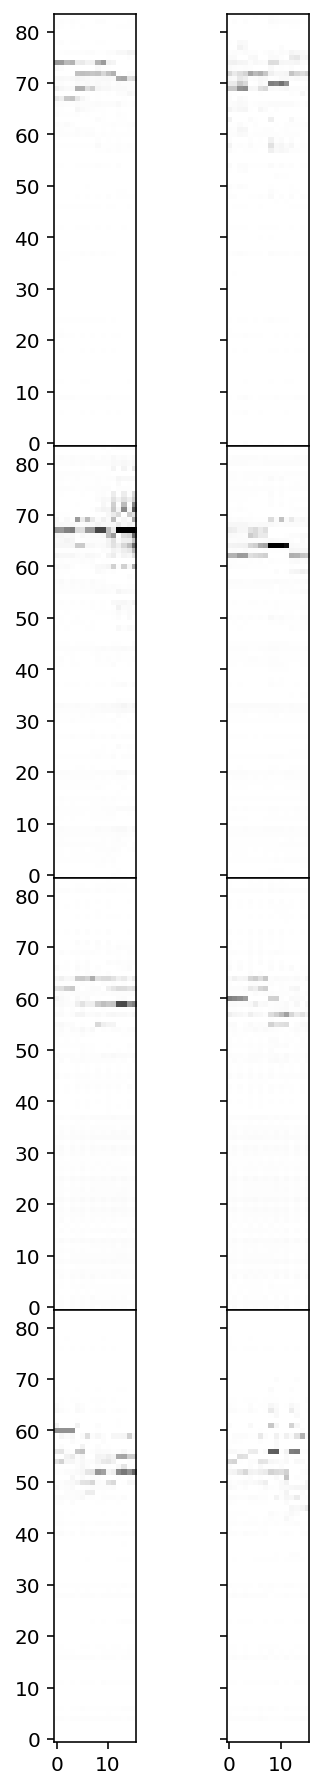

In [ ]:
gan.draw_score(gen_scores, 0)

#Find Closest Match

In [ ]:
def find_closest(data_binary, score):
    current_dist = 99999999
    current_i = -1
    for i, d in enumerate(data_binary):
        dist = np.sqrt(np.sum(pow((d - score),2)))
        if dist < current_dist:
            current_i = i
            current_dist = dist
        
    return current_i

In [ ]:
closest_idx = find_closest(data_binary, gen_scores[0])
closest_data = data_binary[[closest_idx]]
print(closest_idx)

47


original


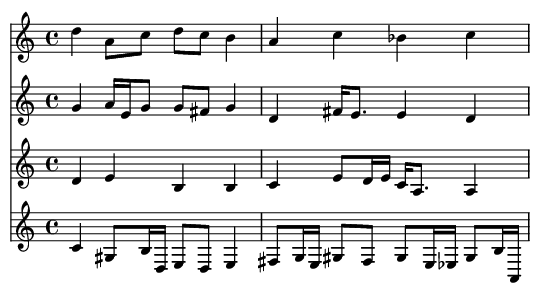

closest


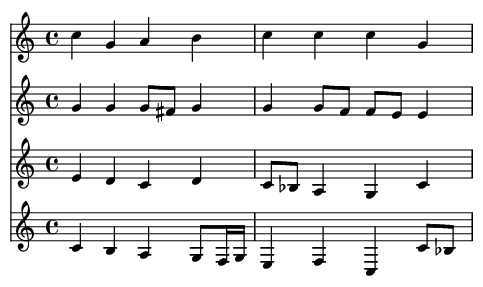

In [ ]:
filename = 'closest'
gan.notes_to_midi(RUN_FOLDER, closest_data,filename)
closest_score = music21.converter.parse(os.path.join(RUN_FOLDER, 'samples/{}.midi'.format(filename)))
print('original')
show(gen_score)
print('closest')
show(closest_score)

In [ ]:
print('original')
play(gen_score)
print('closest')
play(closest_score)

original


closest


#Changing Chord Noises

In [ ]:
chords_noise_2 = 5 * np.ones((1, gan.z_dim))

In [ ]:
chords_scores = gan.generator.predict([chords_noise_2, style_noise, melody_noise, groove_noise])

original


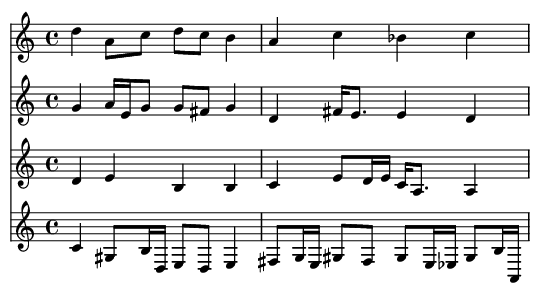

chords noise changed


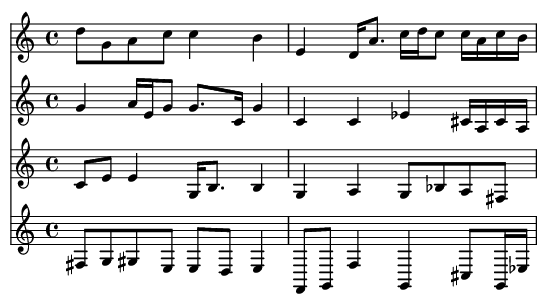

In [ ]:
filename = 'changing_chords'
gan.notes_to_midi(RUN_FOLDER, chords_scores, filename)
chords_score = music21.converter.parse(os.path.join(RUN_FOLDER, 'samples/{}.midi'.format(filename)))
print('original')
show(gen_score)
print('chords noise changed')
show(chords_score)

In [ ]:
print('original')
play(gen_score)
print('chords noise changed')
play(chords_score)

original


chords noise changed


#Changing the Chord Style

In [ ]:
style_noise_2 = 5 * np.ones((1, gan.z_dim))

In [ ]:
style_scores = gan.generator.predict([chords_noise, style_noise_2, melody_noise, groove_noise])

original


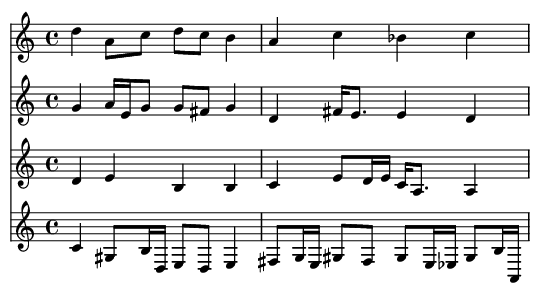

style noise changed


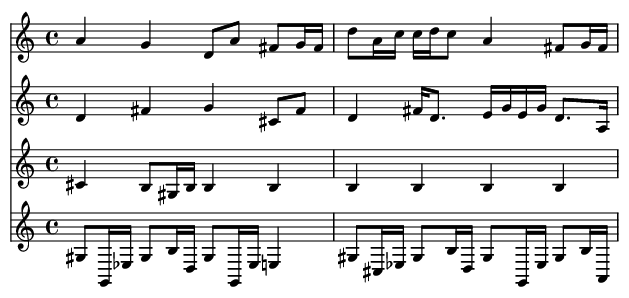

In [ ]:
filename = 'changing_style'
gan.notes_to_midi(RUN_FOLDER, style_scores, filename)
style_score = music21.converter.parse(os.path.join(RUN_FOLDER, 'samples/{}.midi'.format(filename)))
print('original')
show(gen_score)
print('style noise changed')
show(style_score)

In [ ]:
print('original')
play(gen_score)
print('style noise changed')
play(style_score)

original


style noise changed


#Changing the Melody Noise

In [ ]:
melody_noise_2 = np.copy(melody_noise)
melody_noise_2[0,0,:] = 5 * np.ones(gan.z_dim)

In [ ]:
melody_scores = gan.generator.predict([chords_noise, style_noise, melody_noise_2, groove_noise])

original


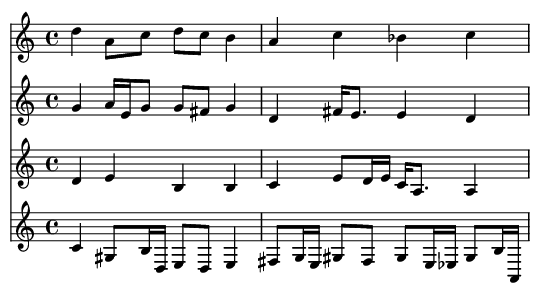

melody noise changed


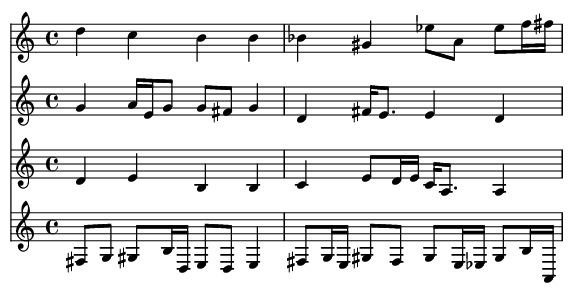

In [ ]:
filename = 'changing_melody'
gan.notes_to_midi(RUN_FOLDER, melody_scores, filename)
melody_score = music21.converter.parse(os.path.join(RUN_FOLDER, 'samples/{}.midi'.format(filename)))
print('original')
show(gen_score)
print('melody noise changed')
show(melody_score)

In [ ]:
print('original')
play(gen_score)
print('melody noise changed')
play(melody_score)

original


melody noise changed


#Changing the Groove Noise

In [ ]:
groove_noise_2 = np.copy(groove_noise)
groove_noise_2[0,3,:] = 5 * np.ones(gan.z_dim)

In [ ]:
groove_scores = gan.generator.predict([chords_noise, style_noise, melody_noise, groove_noise_2])

original


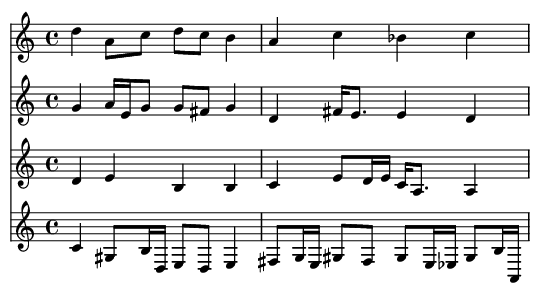

groove noise changed


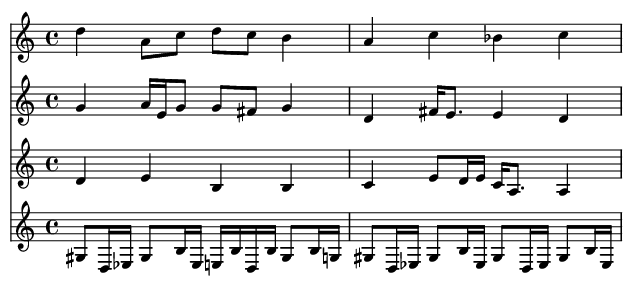

In [ ]:
filename = 'changing_groove'
gan.notes_to_midi(RUN_FOLDER, groove_scores, filename)
groove_score = music21.converter.parse(os.path.join(RUN_FOLDER, 'samples/{}.midi'.format(filename)))
print('original')
show(gen_score)
print('groove noise changed')
show(groove_score)

In [ ]:
print('original')
play(gen_score)
print('groove noise changed')
play(groove_score)

original


groove noise changed
